# Examen 2 - Análisis de Datos


In [2]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [3]:
data = pd.read_csv('http://www2.udec.cl/~jorgecastillo/AirPassengers.txt', sep=',') 
data.rename(columns = {'#Passengers': "pasajeros", "Month":'date'}, inplace=True)
data.head()

,date,pasajeros
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Paso campo `mes` a datetime

In [4]:
data['date'] = pd.to_datetime(data.loc[:,'date'])
data.describe()

,pasajeros
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Vemos cómo es la serie de tiempo

Text(0.5, 1.0, 'Serie de tiempo - Pasajeros')

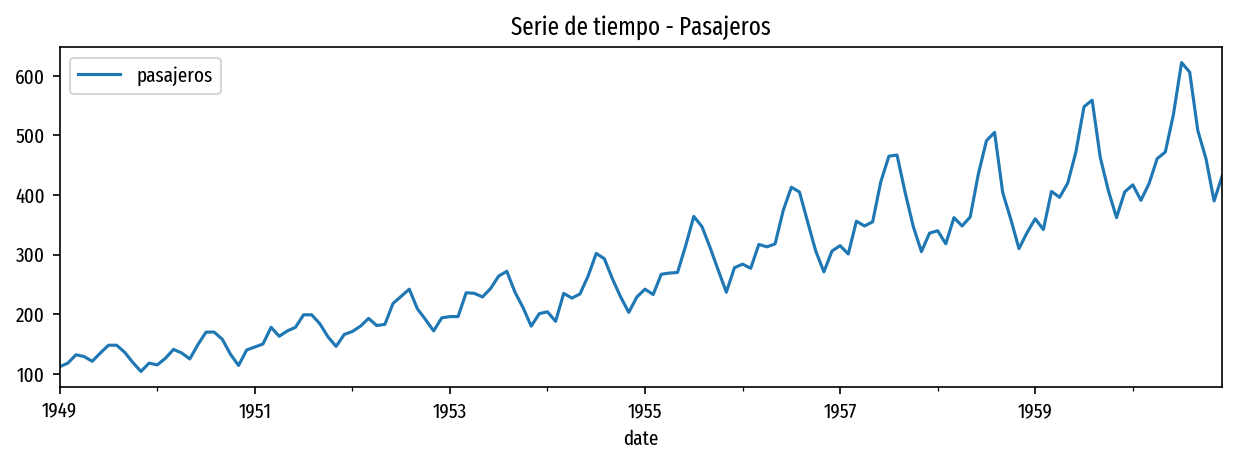

In [5]:
fig, ax = plt.subplots(figsize=(10,3))
data.plot(x='date',y='pasajeros',ax=ax).set_title('Serie de tiempo - Pasajeros')

### 1.a) Comentar acerca de la tendencia:   
R:  El número de pasajeros aumenta a medida que pasa el tiempo lo cual indica que la tendencia es creciente. Esto queda claro al descomponer la serie de tiempo. Se puede ver que la pendiente que tiene la curva de tendencia es positiva.

### 1.b) Comentar acerca de su estacionalidad:  
R: Hay prescencia de componentes estacionales cada año. Esto puede ser debido a las temporadas de verano, en donde aumenta el número de viajes y por ende la cantidad de pasajeros.  Se aprecia claramente en el gráfico de estacionalidad al descomponer la serie de tiempo. En cada año hay un aumento considerable en la época de verano europeo. Además, podemos ver que la amplitud de la estacionalidad es mayor a medida que aumenta la pendiente de la tendencia, por lo que podemos concluir que la serie es **multiplicativa**.

### 1.c) Comentar sobre sus schocks aleatorios, irregularidades, etc.:  
R: A priori no se aprecia presencia de ciclicidad o shocks aleatorios en la serie de tiempo, tampoco de grandes irregularidades en los residuos. 

Podemos ver que la serie presenta una tendencia creciente y que posee cierta estacionalidad. Además la amplitud de la estacionalidad es mayor a medida que aumenta la pendiente de la tendencia, por lo que sería una serie multiplicativa.

## Descompisición de la varianza

In [6]:
result=seasonal_decompose(data['pasajeros'], model='multiplicable', period=12)

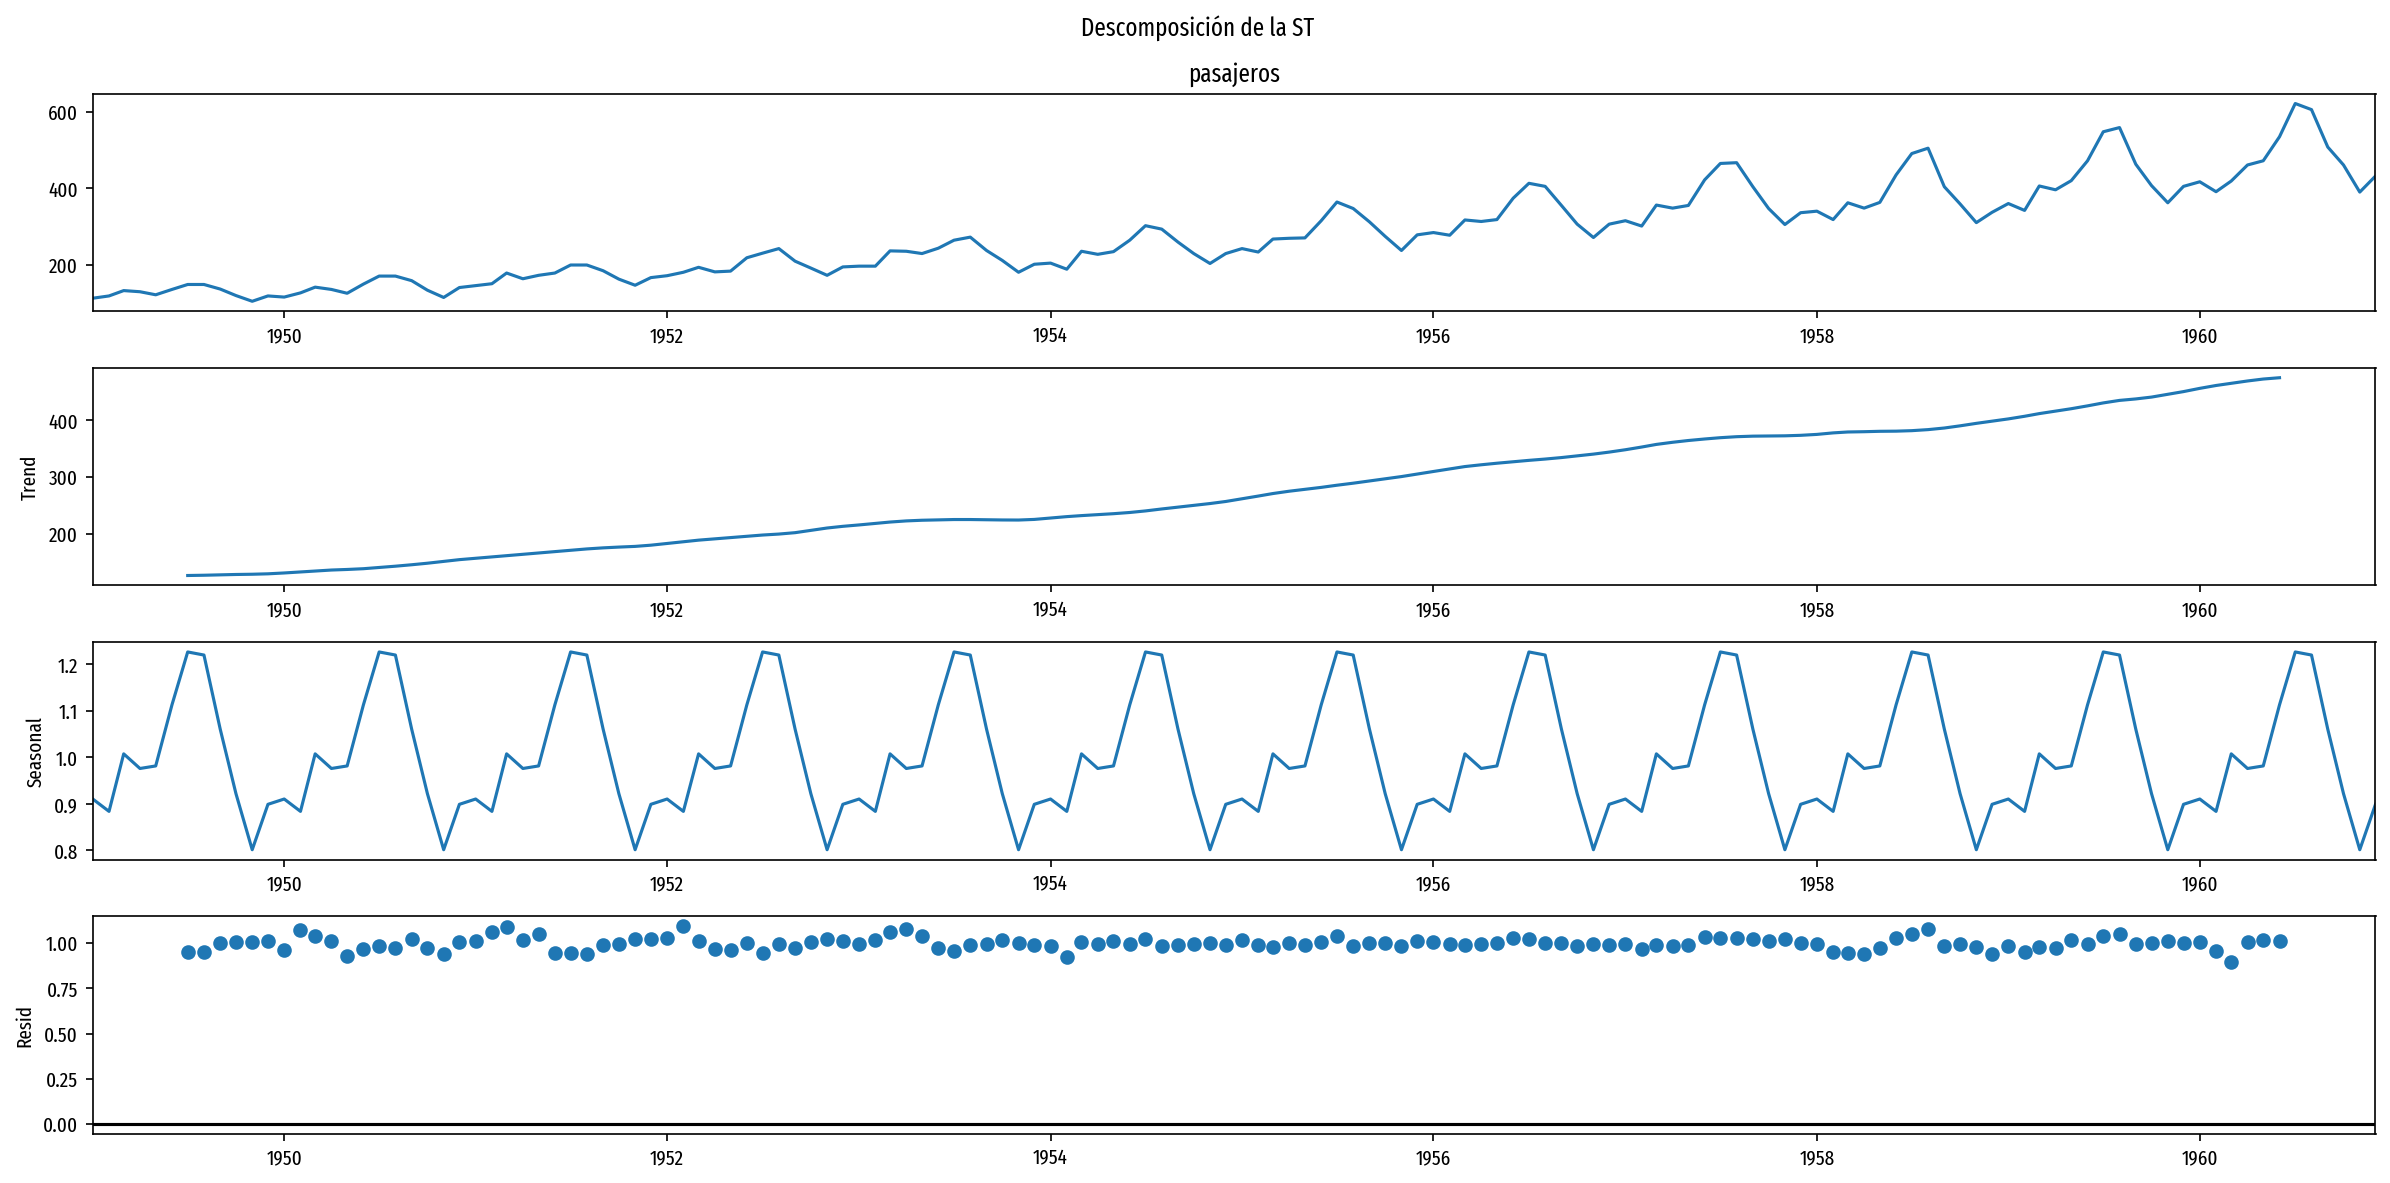

In [7]:
decomposition = seasonal_decompose(
    data.set_index('date').pasajeros,
    period=12,
    model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(16, 8)
fig.suptitle('Descomposición de la ST')
fig.tight_layout()

### Utilizando STL

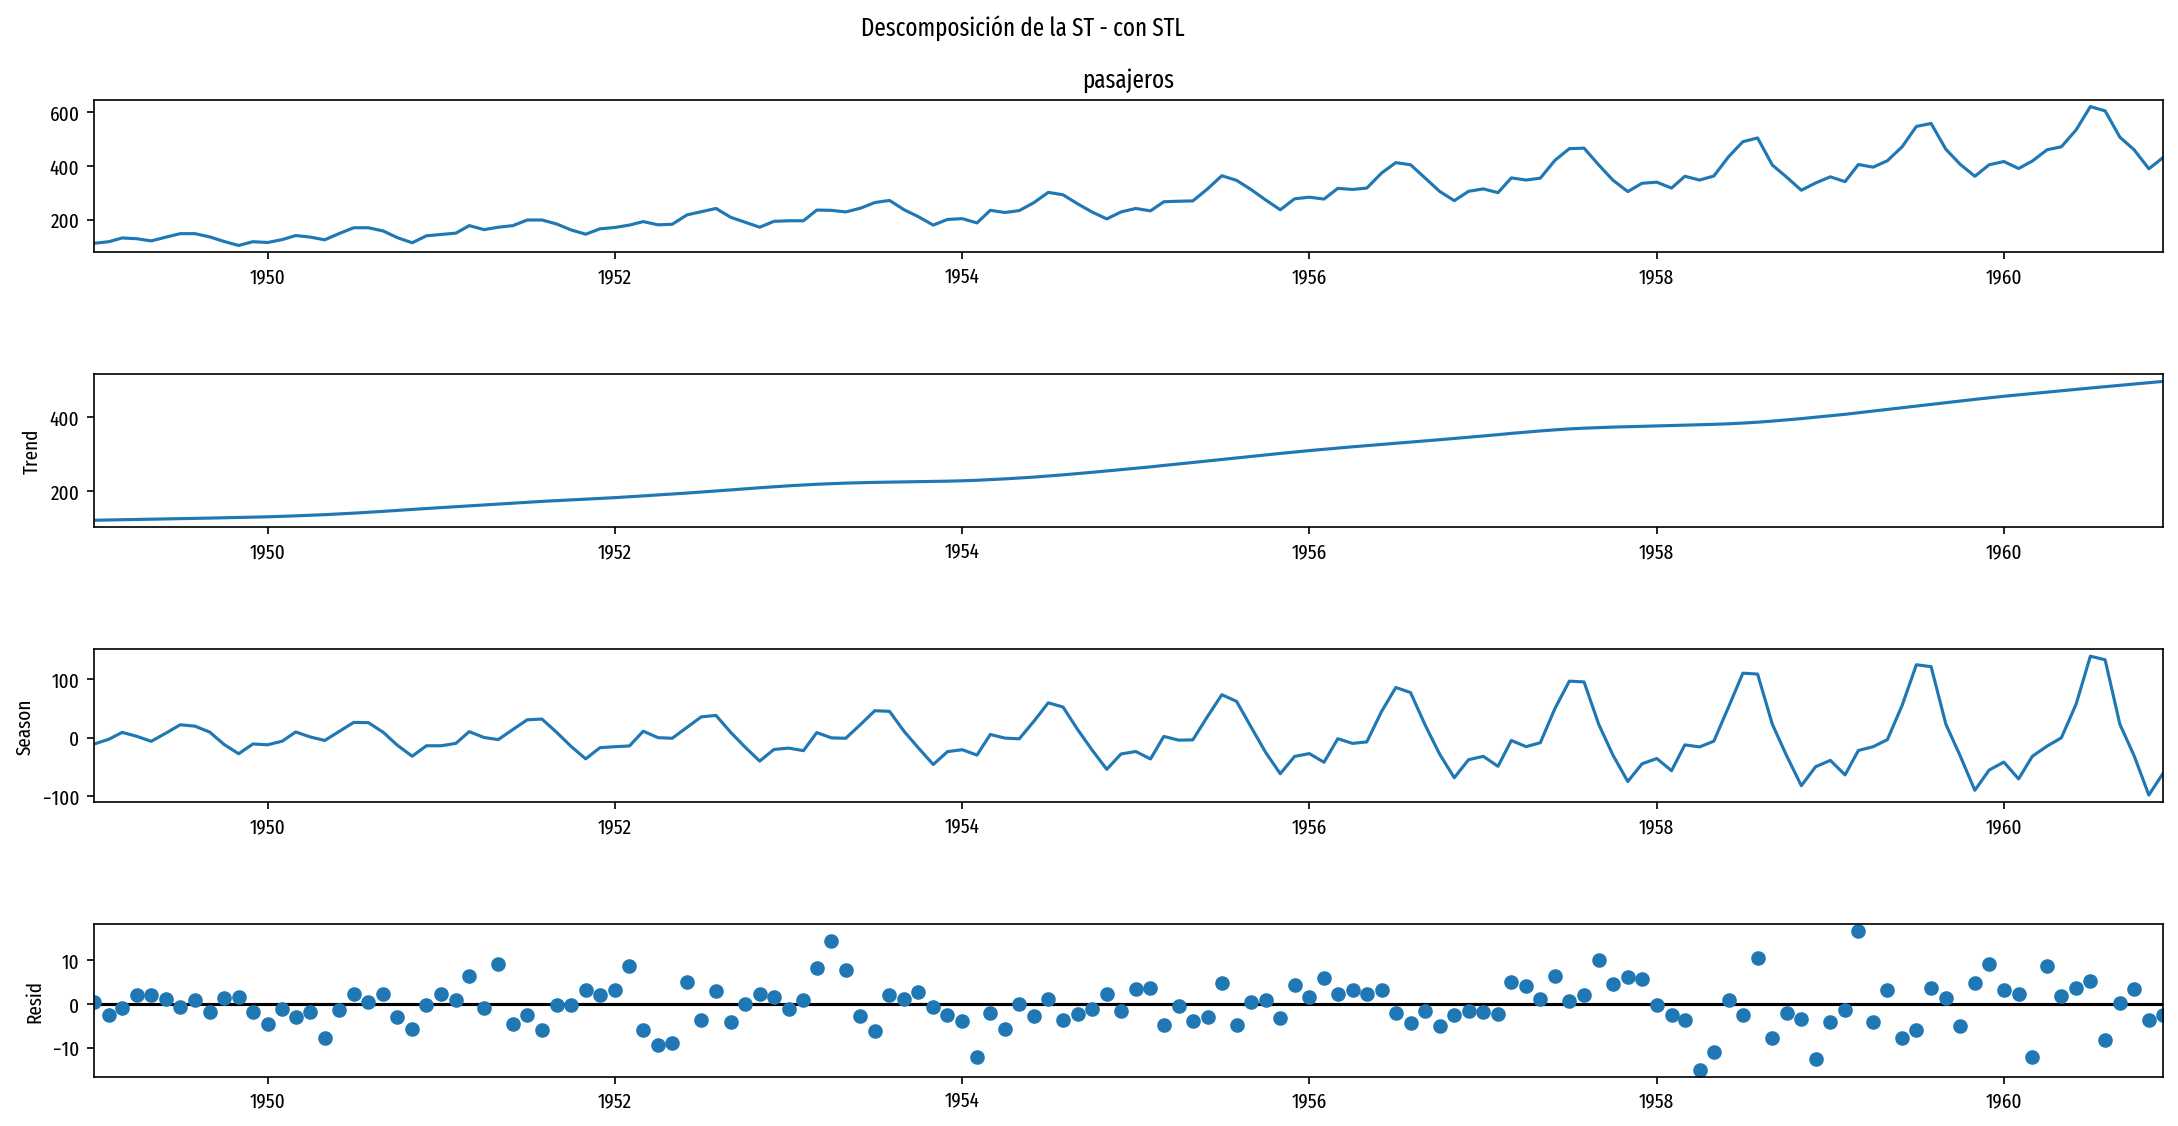

In [8]:
decomposition2 = STL(data.set_index('date').pasajeros, period=12).fit()

fig2 = decomposition2.plot()
fig2.suptitle('Descomposición de la ST - con STL')
fig2.set_size_inches(16, 8)

Text(0.5, 1.0, 'Descomposición de la serie de tiempo - Estacionalidad')

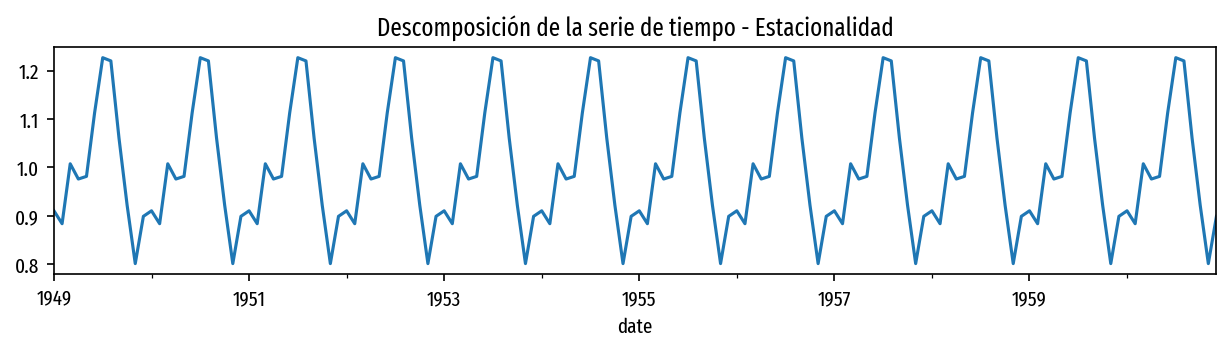

In [9]:
fig, ax = plt.subplots(figsize=(10,2))
decomposition.seasonal.plot().set_title('Descomposición de la serie de tiempo - Estacionalidad')

### 1.d)Analizar ACF y PACF y comentar acerca de lo que se ve en los correlogramas

/Users/fabianalexis/opt/anaconda3/envs/analisis-de-datos/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


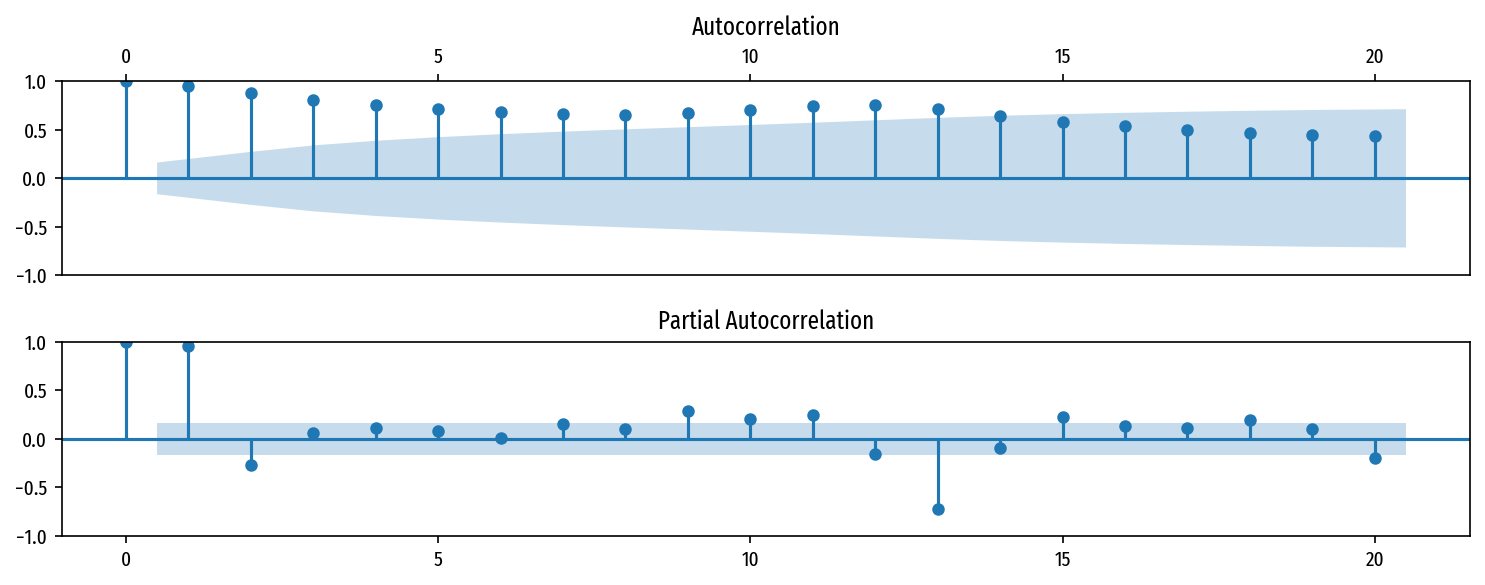

In [10]:
# Para un modelo AR es mejor PACF, para un modelo MA es mejor ACF

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.set_index('date').pasajeros, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('top')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.set_index('date').pasajeros,lags=20, ax=ax2)
fig.tight_layout()

El gráfico ACF muestra un rezago significativo hasta el mes 15. Mientras que el gráfico del PACF muetra rezagos significativos hasta el mes 3, y luego en el 9,10,11, 13 y 20. 
ARIMA(15,0,3)

Estacionariedad de la serie

In [11]:
from statsmodels.tsa.stattools import adfuller

def is_stationary_with_adf(data, significance_level=0.01):
    """Decide if the given time series is stationary using ADF test."""
    test = adfuller(data, regression='c', autolag='BIC')
    p_value = test[1]
    print("ADF p-value: {:0.5f}".format(p_value))
    return print(test)

In [12]:
is_stationary_with_adf(data.set_index('date').pasajeros)

ADF p-value: 0.99188
(0.8153688792060442, 0.9918802434376409, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 1039.5901169044441)


ADF

Ho: Posee raiz unitaria ( No es estacionaria)

In [13]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data.set_index('date').pasajeros, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Results of Dickey-Fuller Test:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Diferenciamos series para remover estacionariedad con media móvil

In [14]:
ts = data.set_index('date').pasajeros

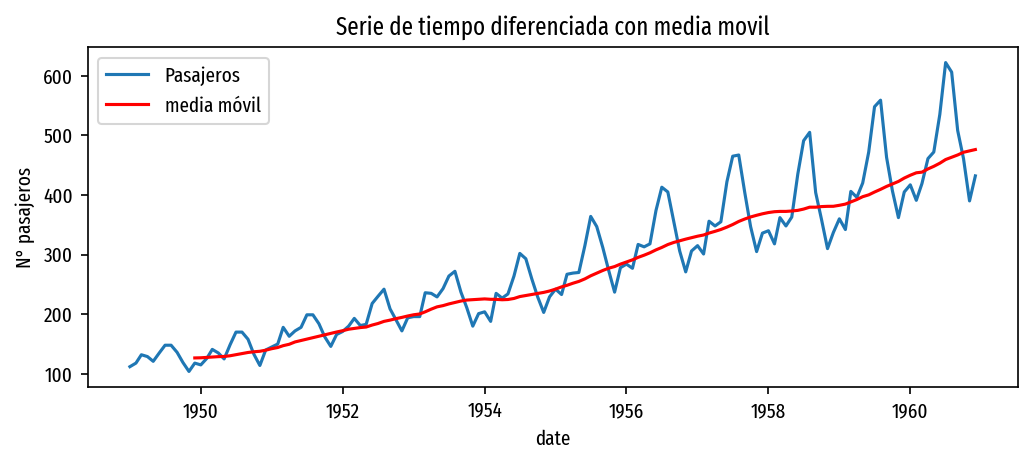

In [23]:
moving_avg = ts.rolling(12).mean()
plt.figure(figsize=(8,3))
plt.plot(ts, label = 'Pasajeros')
plt.plot(moving_avg, color='red', label = 'media móvil')
plt.legend()
plt.xlabel('date',)
plt.ylabel('N° pasajeros' )
plt.title('Serie de tiempo diferenciada con media movil')
plt.show()

testeamos estacionariedad 

In [16]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True)
ts_moving_avg_diff.head()

date
1949-12-01    -8.666667
1950-01-01   -11.916667
1950-02-01    -1.583333
1950-03-01    12.666667
1950-04-01     6.166667
Name: pasajeros, dtype: float64

In [17]:
is_stationary_with_adf(ts_moving_avg_diff)

ADF p-value: 0.02210
(-3.164968129955146, 0.022104139473878785, 13, 119, {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}, 947.9747375467673)


In [18]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_moving_avg_diff,autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Results of Dickey-Fuller Test:


Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

Podemos afirmar al 95% de confianza que la serie diferenciada es estacionaria. 

### Prueba con diferenciación de 1 lag

In [19]:
ts_seasonal_first_difference= ts - ts.shift(12)  

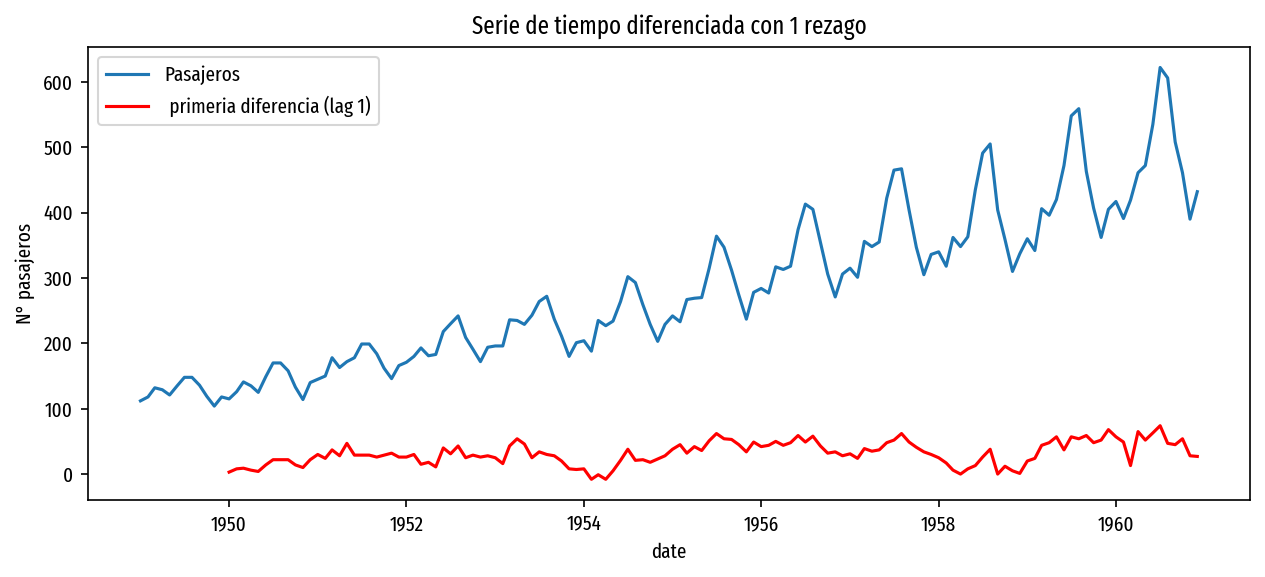

In [25]:
plt.figure(figsize=(10,4))
plt.plot(ts, label = 'Pasajeros')
plt.plot(ts_seasonal_first_difference, color='red', label = ' primeria diferencia (lag 1)')
plt.legend()
plt.xlabel('date',)
plt.ylabel('N° pasajeros' )
plt.title('Serie de tiempo diferenciada con 1 rezago')
plt.show()

In [21]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_seasonal_first_difference.dropna(inplace=False),autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Results of Dickey-Fuller Test:


Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

### Volvemos a analizar ACF Y PACF

/Users/fabianalexis/opt/anaconda3/envs/analisis-de-datos/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


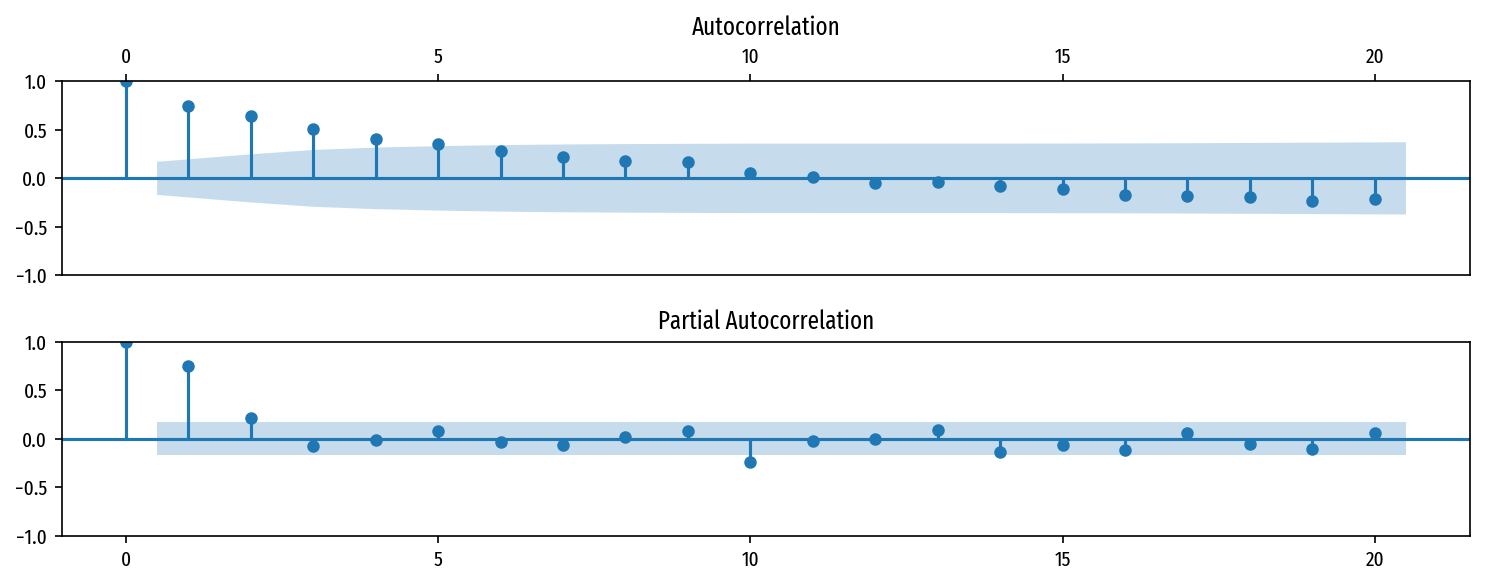

In [22]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_seasonal_first_difference.dropna(inplace=False), lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('top')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_seasonal_first_difference.dropna(inplace=False),lags=20, ax=ax2)
fig.tight_layout()

por lo que el AR p seria 6, y el MA q sería 3.